In [95]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from random import random
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
import scipy as sp
import scipy.signal
import scipy.io.wavfile
import matplotlib.animation as animation
from time import time
from IPython.display import HTML
from tqdm import tqdm
import librosa
import torch
import ot as pot
from scipy.interpolate import interp1d
import SoundWassersteinBarycenter as SWB

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# A set of exemple

# On pure note

In [96]:
F = 50
T = 50

n = 50
a = n//5
b = 3*n//5

r = np.arange(F)
t = np.arange(T)

M1 = np.zeros((F,T))
M1[a,:] = np.ones(T)
M1 = M1/np.sum(M1)

M2 = np.zeros((F,T))
M2[b,:] = np.ones(T)
M2 = M2/np.sum(M2)

M3_quantile, _ = SWB.barycenter_quantile(M1, M2, alpha=0.5)
M3_unbalanced,_ = SWB.barycenter_unbalanced(M1, M2, alpha = 0.5, epsilon = 1e-2, reg = 0.3)

fc = lambda nn, pp : (np.arange(pp)**2/((nn-1)**2+(pp-1)**2))
fd = lambda nn, pp : (np.arange(nn)**2/((nn-1)**2+(pp-1)**2))

M3_sinkhorn,_= SWB.efficient_sinkhorn(M1, M2, p=T, d=fd, c=fc, epsilon = 0.01, alpha = 0.5, numItermax = 10)
M3_sinkhorn_2,_= SWB.efficient_sinkhorn(M1, M2, p=T//2, d=fd, c=fc, epsilon = 0.01, alpha = 0.5, numItermax=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 62.86it/s]
C:\Users\Utilisateur\Documents\Stage_IRIT\code\SoundWassersteinBarycenter.py:677: RuntimeWarning: divide by zero encountered in log
  def geometricMean(a,b):
C:\Users\Utilisateur\Documents\Stage_IRIT\code\SoundWassersteinBarycenter.py:728: RuntimeWarning: invalid value encountered in true_divide
  gm = geometricMean(UKv1, UKv2)
C:\Users\Utilisateur\Documents\Stage_IRIT\code\SoundWassersteinBarycenter.py:729: RuntimeWarning: invalid value encountered in true_divide
  
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.98it/s]


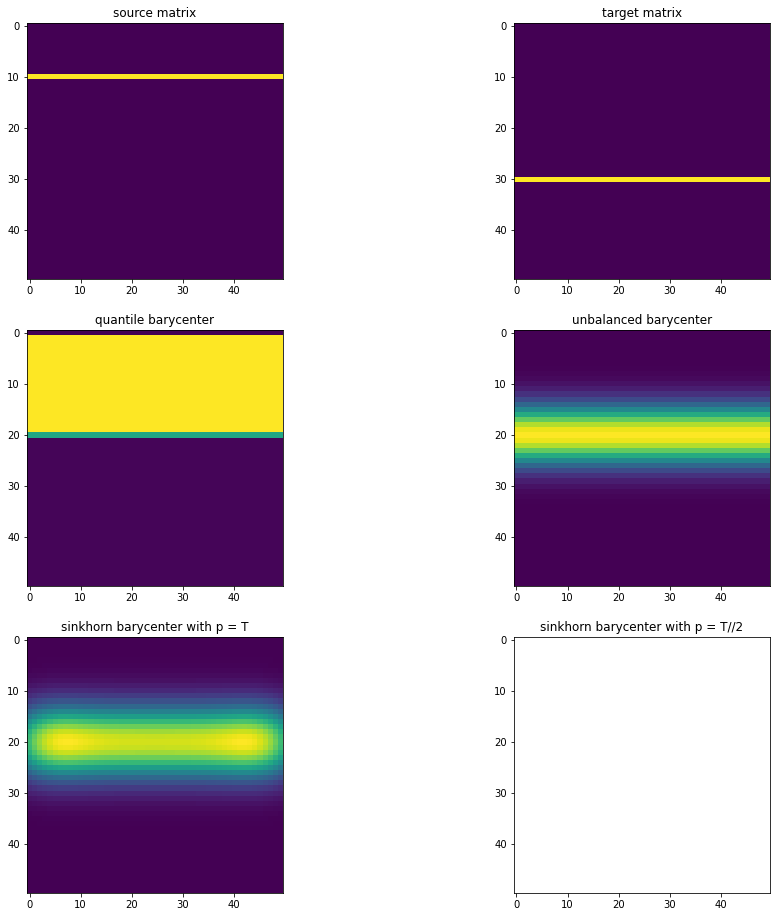

In [97]:
fig, ax = plt.subplots(3 , 2, figsize=(16,16))
ax[0,0].imshow(M1)
ax[0,0].set_title('source matrix')
ax[0,1].imshow(M2)
ax[0,1].set_title('target matrix')
ax[1,0].imshow(M3_quantile)
ax[1,0].set_title('quantile barycenter')
ax[1,1].imshow(M3_unbalanced)
ax[1,1].set_title('unbalanced barycenter')
ax[2,0].imshow(M3_sinkhorn)
ax[2,0].set_title('sinkhorn barycenter with p = T')
ax[2,1].imshow(M3_sinkhorn_2)
ax[2,1].set_title('sinkhorn barycenter with p = T//2')
plt.show()

Comments :
- the quantile barycenter isn't pertinent with dirac distribution because approximation in the cdf don't work well
- unbalanced barycenter give a good result but regularize
- the sinkhorn barycenter give the expected result in 2D with $p=T$ ($T$ the number of frame) but artefact in the limit of the domain and a regularization
- If $p$ is too small the transport is impossible so we have numerical break such as for $p=T//2$ because the sparsity of the matrices is hard imply numerical break.

## On frequency localised gaussian

In [98]:
F = 50
T = 50

n = 50
a = n//5
b = 3*n//5
s1 = n//40
s2 = n//20

r = np.arange(F)

M1 = np.exp(-(r-a)**2/(2*s1**2))[:,None]*np.ones(T)[None,:]
M1 = M1/np.sum(M1)
print(M1.shape)
M2 = np.exp(-(r[:,None]-b)**2/(2*s2**2))*np.ones(T)[None,:]
M2 = M2/np.sum(M2)

M3_quantile, _ = SWB.barycenter_quantile(M1, M2, alpha=0.5)
M3_unbalanced, _ = SWB.barycenter_unbalanced(M1, M2, alpha = 0.5, epsilon = 1e-3, reg = 0.3)

fc = lambda nn, pp : (np.arange(pp)**2/((nn-1)**2+(pp-1)**2))
fd = lambda nn, pp : (np.arange(nn)**2/((nn-1)**2+(pp-1)**2))

M3_sinkhorn,_= SWB.efficient_sinkhorn(M1, M2, p=T, d=fd, c=fc, epsilon = 0.01, alpha = 0.5, numItermax = 10)
M3_sinkhorn_2,_= SWB.efficient_sinkhorn(M1, M2, p=T//2, d=fd, c=fc, epsilon = 0.01, alpha = 0.5, numItermax=10)

(50, 50)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 64.63it/s]


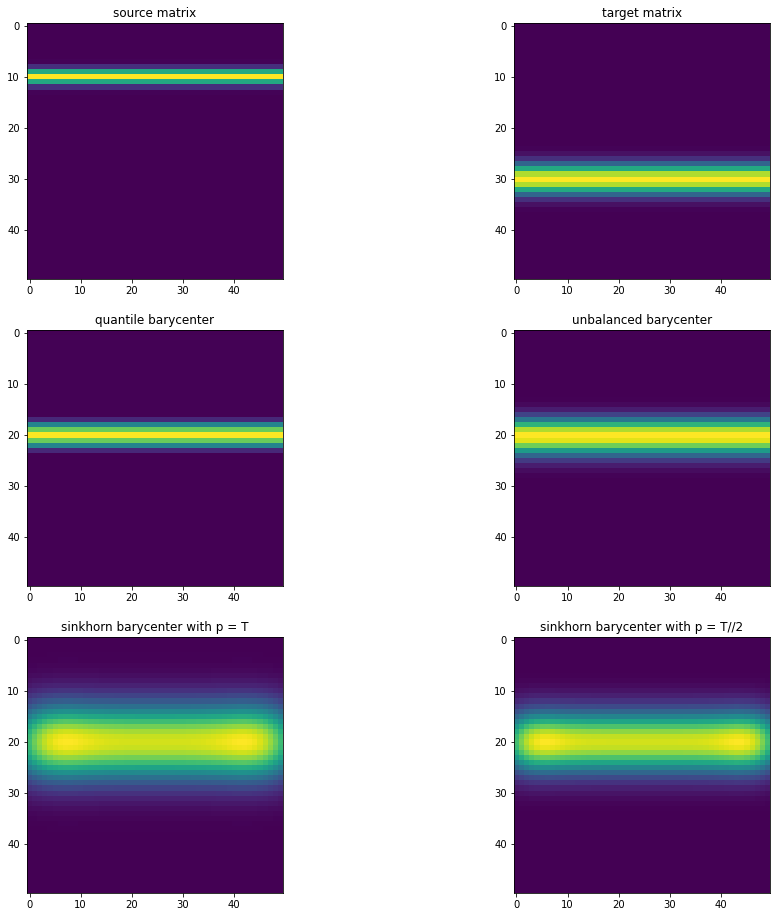

In [99]:
fig, ax = plt.subplots(3 , 2, figsize=(16,16))
ax[0,0].imshow(M1)
ax[0,0].set_title('source matrix')
ax[0,1].imshow(M2)
ax[0,1].set_title('target matrix')
ax[1,0].imshow(M3_quantile)
ax[1,0].set_title('quantile barycenter')
ax[1,1].imshow(M3_unbalanced)
ax[1,1].set_title('unbalanced barycenter')
ax[2,0].imshow(M3_sinkhorn)
ax[2,0].set_title('sinkhorn barycenter with p = T')
ax[2,1].imshow(M3_sinkhorn_2)
ax[2,1].set_title('sinkhorn barycenter with p = T//2')
plt.show()

Comments : 
It's a more realistic model because their is no zeros in $M_1$ or $M_2$.
- the quantile barycenter give a perfect result
- unbalanced barycenter give a good result but regularize
- the sinkhorn barycenter give the expected result in 2D with $p=T$ ($T$ the number of frame) but artefact in the limit of the domain and a regularization
- We can reduce $p$, the algorithm is faster and give a close result

## On Gaussian
Just to see the algorithme run, we put it with gaussians.

In [100]:
F = 50
T = 50

n = 50
a = n//5
b = 3*n//5
s1 = n//20
s2 = n//10
u1 = n//5
u2 = n//10

r = np.arange(F)
t = np.arange(T)

M1 = np.exp(-((r[:,None]-a)**2/(2*s1**2))-((t[None,:]-a)**2)/(2*s2**2))
M1 = M1/np.sum(M1)
M2 = np.exp(-((r[:,None]-b)**2/(2*u1**2))-((t[None,:]-b-10)**2)/(2*u2**2))
M2 = M2/np.sum(M2)

M3_quantile, _ = SWB.barycenter_quantile(M1, M2, alpha=0.5)
M3_unbalanced, _ = SWB.barycenter_unbalanced(M1, M2, alpha = 0.5, epsilon = 1e-2, reg = 0.3)

fc = lambda nn, pp : (np.arange(pp)**2/((nn-1)**2+(pp-1)**2))
fd = lambda nn, pp : (np.arange(nn)**2/((nn-1)**2+(pp-1)**2))

M3_sinkhorn,_= SWB.efficient_sinkhorn(M1, M2, p=T, d=fd, c=fc, epsilon = 0.01, alpha = 0.5)
M3_sinkhorn_2,_= SWB.efficient_sinkhorn(M1, M2, p=T//2, d=fd, c=fc, epsilon = 0.01, alpha = 0.5)

  0%|                                                                                          | 0/300 [00:00<?, ?it/s]C:\Users\Utilisateur\Documents\Stage_IRIT\code\SoundWassersteinBarycenter.py:681: RuntimeWarning: invalid value encountered in log
  def geometricBar(alpha, a, b):
100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 60.59it/s]


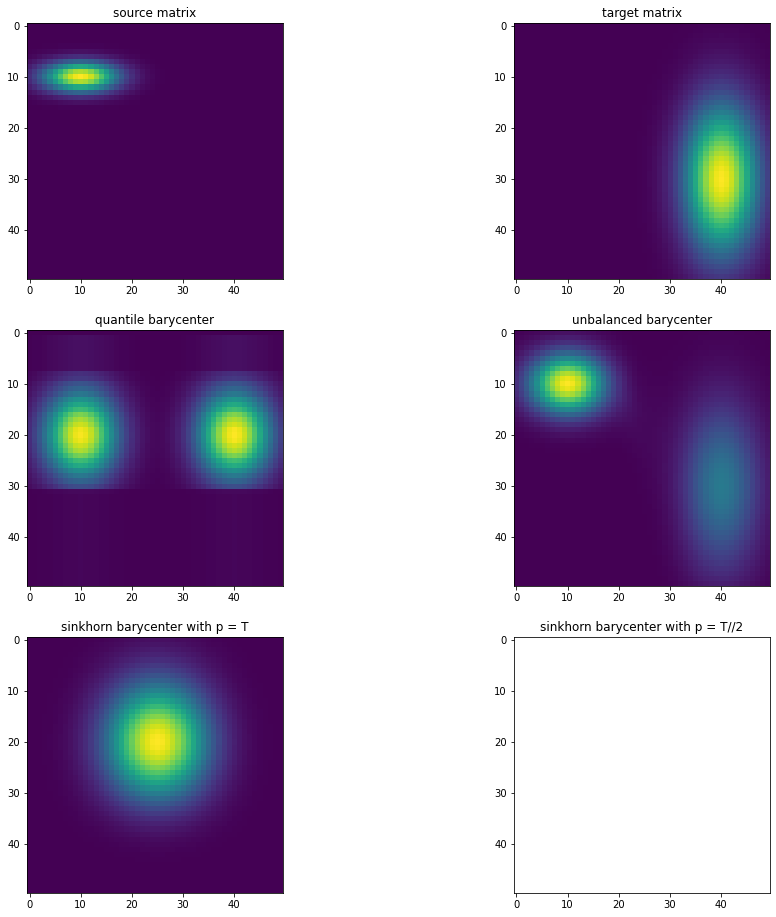

In [101]:
fig, ax = plt.subplots(3 , 2, figsize=(16,16))
ax[0,0].imshow(M1)
ax[0,0].set_title('source matrix')
ax[0,1].imshow(M2)
ax[0,1].set_title('target matrix')
ax[1,0].imshow(M3_quantile)
ax[1,0].set_title('quantile barycenter')
ax[1,1].imshow(M3_unbalanced)
ax[1,1].set_title('unbalanced barycenter')
ax[2,0].imshow(M3_sinkhorn)
ax[2,0].set_title('sinkhorn barycenter with p = T')
ax[2,1].imshow(M3_sinkhorn_2)
ax[2,1].set_title('sinkhorn barycenter with p = T//2')
plt.show()

Comments :
- the quantile barycenter isn't pertinent because we try to displace mass from a gaussian to a quasi-zero gaussian (on each frame)
- same comment for the unbalanced barycenter
- the sinkhorn barycenter give the expected result in 2D with $p=T$ ($T$ the number of frame)
- If $p$ is too small the transport is impossible so we have numerical break such as for $p=T//2$

In [102]:
F = 50
T = 50

n = 50
a = n//5
b = 3*n//5
s1 = n//20
s2 = n//10
u1 = n//5
u2 = n//10

r = np.arange(F)
t = np.arange(T)

M1 = np.exp(-((r[:,None]-a)**2/(2*s1**2))-((t[None,:]-a)**2)/(2*s2**2))
M1 = M1/np.sum(M1)
M2 = np.exp(-((r[:,None]-b)**2/(2*u1**2))-((t[None,:]-a)**2)/(2*u2**2))
M2 = M2/np.sum(M2)

M3_quantile, _ = SWB.barycenter_quantile(M1, M2, alpha=0.5)
M3_unbalanced, _ = SWB.barycenter_unbalanced(M1, M2, alpha = 0.5, epsilon = 1e-2, reg = 0.3)

fc = lambda nn, pp : (np.arange(pp)**2/((nn-1)**2+(pp-1)**2))
fd = lambda nn, pp : (np.arange(nn)**2/((nn-1)**2+(pp-1)**2))

M3_sinkhorn,_= SWB.efficient_sinkhorn(M1, M2, p=T, d=fd, c=fc, epsilon = 0.01, alpha = 0.5)
M3_sinkhorn_2,_= SWB.efficient_sinkhorn(M1, M2, p=T//2, d=fd, c=fc, epsilon = 0.01, alpha = 0.5)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 74.88it/s]


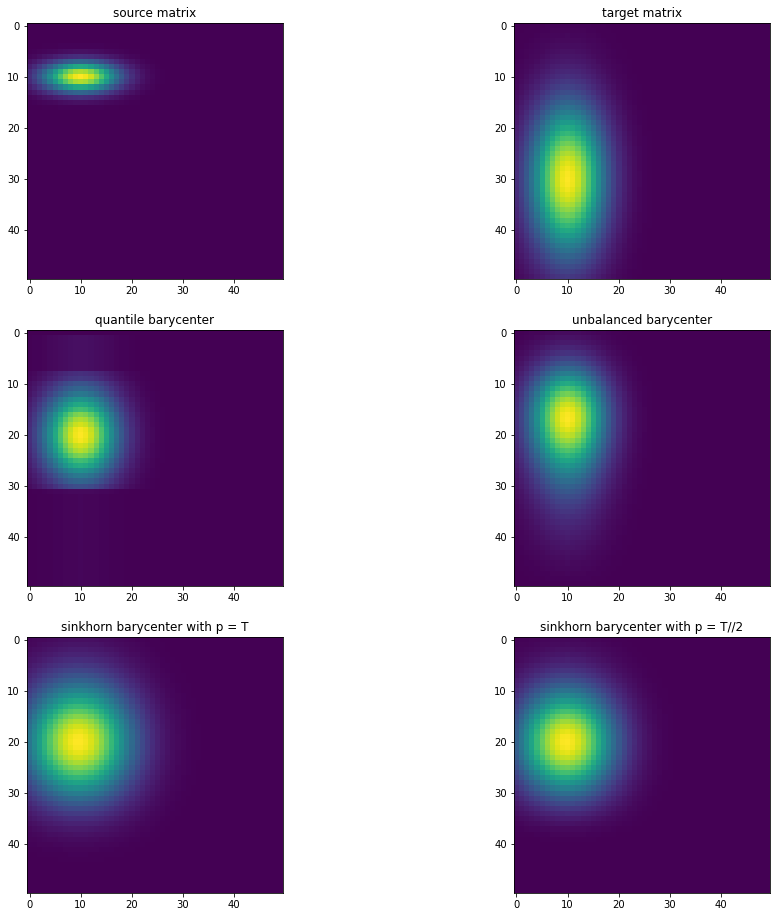

In [103]:
fig, ax = plt.subplots(3 , 2, figsize=(16,16))
ax[0,0].imshow(M1)
ax[0,0].set_title('source matrix')
ax[0,1].imshow(M2)
ax[0,1].set_title('target matrix')
ax[1,0].imshow(M3_quantile)
ax[1,0].set_title('quantile barycenter')
ax[1,1].imshow(M3_unbalanced)
ax[1,1].set_title('unbalanced barycenter')
ax[2,0].imshow(M3_sinkhorn)
ax[2,0].set_title('sinkhorn barycenter with p = T')
ax[2,1].imshow(M3_sinkhorn_2)
ax[2,1].set_title('sinkhorn barycenter with p = T//2')
plt.show()

Comments :
- the quantile barycenter give a good result and we see the artefacts due to the cdf approximation in the extremum of the gaussian
- the unbalanced barycenter give also a good result. But it's harder to choose correctly $\alpha$ and $reg$ at the same time
- the sinkhorn barycenter give the expected result
- If $p$ is smaller the result stay similar because we face to a quasi frame by frame optimal transport in this case

## On real sound

In [125]:
adresse1 = "sound/cigale_fontaine/cigale_short.wav"
adresse2 = "sound/cigale_fontaine/fontaine_short.wav"

X1, fs1 = librosa.load(adresse1, sr=None)
X2, fs2 = librosa.load(adresse2, sr=None)

length = min(len(X1), len(X2))
length0 = 30000
length = 40000
print("length = ", length)

X1 = X1[length0:length]
X2 = X2[length0:length]
 
nperseg = 2**(round(np.log2(int(fs1*40e-3))))
nperseg = 400
print("nperseg = ",nperseg)

M_f1 = librosa.stft(X1, n_fft=nperseg)
Ms1 = np.abs(M_f1)
M1 = Ms1/np.sum(Ms1)

Fs = len(Ms1)
print('F = ', Fs)
Ts = len(Ms1[0])
print("T = ", Ts)

M_f2 = librosa.stft(X2, n_fft=nperseg)
Ms2 = np.abs(M_f2)
M2 = Ms2/np.sum(Ms2)

length =  40000
nperseg =  400
F =  201
T =  101


In [126]:
M3_quantile, _ = SWB.barycenter_quantile(M1, M2, alpha=0.5)
M3_unbalanced, _ = SWB.barycenter_unbalanced(M1, M2, alpha = 0.5, epsilon = 1e-4, reg = 0.3)

fc = lambda nn, pp : (np.arange(pp)**2/((nn-1)**2+(pp-1)**2))
fd = lambda nn, pp : (np.arange(nn)**2/((nn-1)**2+(pp-1)**2))

M3_sinkhorn,_= SWB.efficient_sinkhorn(M1, M2, p=T, d=fd, c=fc, epsilon = 1e-5, alpha = 0.5, numItermax=10)
M3_sinkhorn_2,_= SWB.efficient_sinkhorn(M1, M2, p=5, d=fd, c=fc, epsilon = 1e-5, alpha = 0.5, numItermax=10)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 22.73it/s]


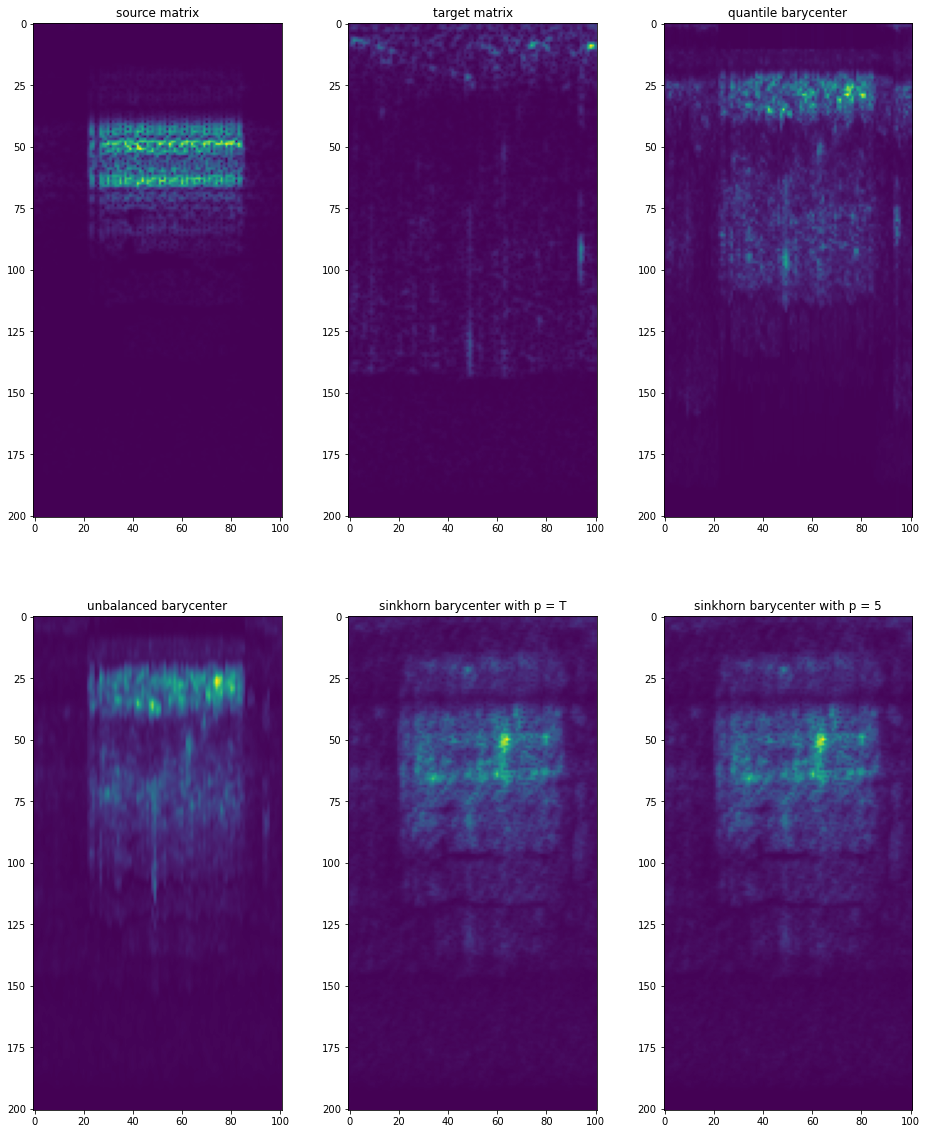

In [127]:
fig, ax = plt.subplots(2 , 3, figsize=(16,20))
ax[0,0].imshow(M1)
ax[0,0].set_title('source matrix')
ax[0,1].imshow(M2)
ax[0,1].set_title('target matrix')
ax[0,2].imshow(M3_quantile)
ax[0,2].set_title('quantile barycenter')
ax[1,0].imshow(M3_unbalanced)
ax[1,0].set_title('unbalanced barycenter')
ax[1,1].imshow(M3_sinkhorn)
ax[1,1].set_title('sinkhorn barycenter with p = T')
ax[1,2].imshow(M3_sinkhorn_2)
ax[1,2].set_title('sinkhorn barycenter with p = 5')
plt.show()

Comments :
    Results are preety good because, the target is unstructure.
- the quantile barycenter give a good result and sparse
- the unbalanced barycenter give also a good result. But it's regularize and the choose of $\alpha$ and $reg$ is hard
- the sinkhorn barycenter give the expected result and very similar result for $p=T$ and for $p=5$. We see that their is band of frequencies without mass and the result is different that for the two 1D methods

In [128]:
adresse1 = "sound/cigale_fontaine/cigale.wav"
adresse2 = "sound/cigale_fontaine/fontaine.wav"

X1, fs1 = librosa.load(adresse1, sr=None)
X2, fs2 = librosa.load(adresse2, sr=None)

length = min(len(X1), len(X2))
print("length = ", length)

X1 = X1[:length]
X2 = X2[:length]
 
nperseg = 2**(round(np.log2(int(fs1*40e-3))))
nperseg = 400
print("nperseg = ",nperseg)

M_f1 = librosa.stft(X1, n_fft=nperseg)
Ms1 = np.abs(M_f1)
M1 = Ms1/np.sum(Ms1)

Fs = len(Ms1)
print('F = ', Fs)
Ts = len(Ms1[0])
print("T = ", Ts)

M_f2 = librosa.stft(X2, n_fft=nperseg)
Ms2 = np.abs(M_f2)
M2 = Ms2/np.sum(Ms2)

length =  135680
nperseg =  400
F =  201
T =  1357


In [129]:
M3_quantile, _ = SWB.barycenter_quantile(M1, M2, alpha=0.5)
M3_unbalanced,_ = SWB.barycenter_unbalanced(M1, M2, alpha = 0.5, epsilon = 1e-4, reg = 0.3)

fc = lambda nn, pp : (np.arange(pp)**2/((nn-1)**2+(pp-1)**2))
fd = lambda nn, pp : (np.arange(nn)**2/((nn-1)**2+(pp-1)**2))

M3_sinkhorn,_= SWB.efficient_sinkhorn(M1, M2, p=T, d=fd, c=fc, epsilon = 1e-5, alpha = 0.5, numItermax=10)
M3_sinkhorn_2,_= SWB.efficient_sinkhorn(M1, M2, p=5, d=fd, c=fc, epsilon = 1e-5, alpha = 0.5, numItermax=10)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.78it/s]


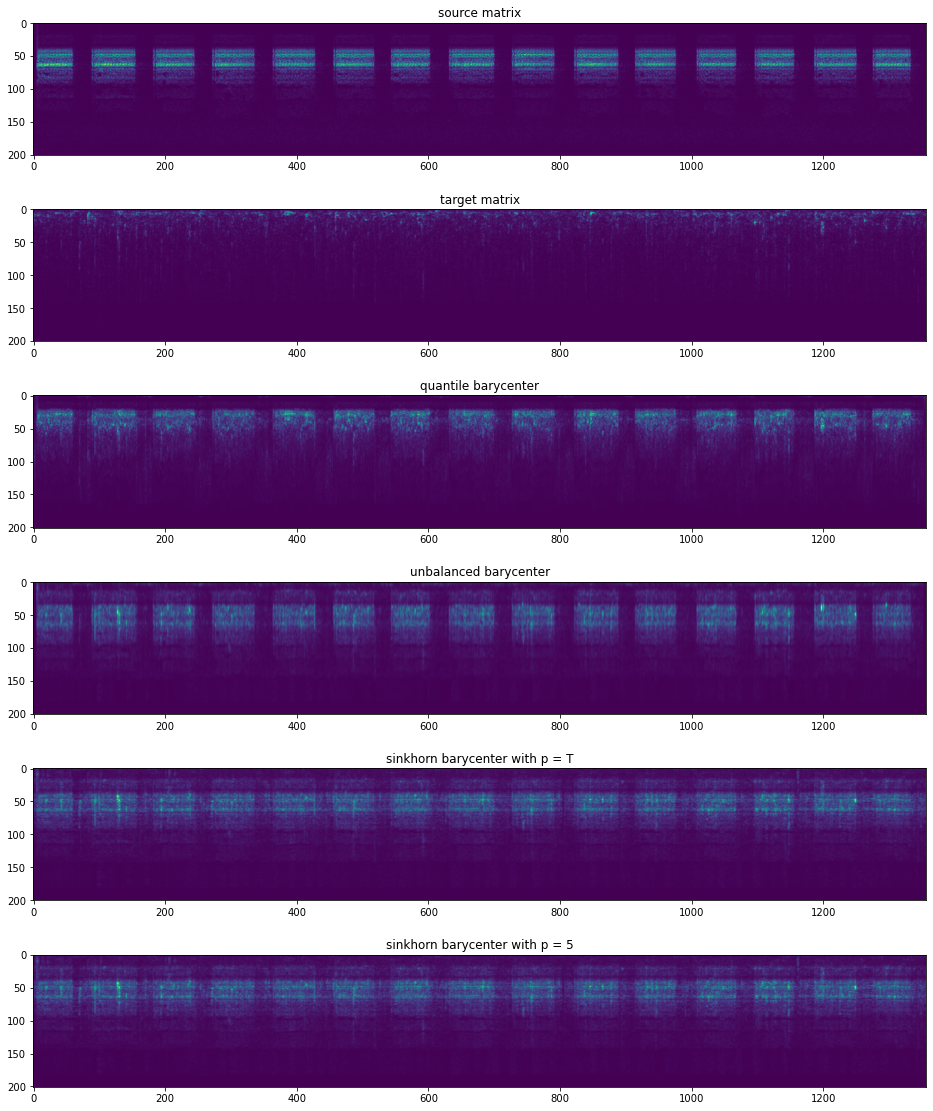

In [131]:
fig, ax = plt.subplots(6 , 1, figsize=(16,20))
ax[0].imshow(M1)
ax[0].set_title('source matrix')
ax[1].imshow(M2)
ax[1].set_title('target matrix')
ax[2].imshow(M3_quantile)
ax[2].set_title('quantile barycenter')
ax[3].imshow(M3_unbalanced)
ax[3].set_title('unbalanced barycenter')
ax[4].imshow(M3_sinkhorn)
ax[4].set_title('sinkhorn barycenter with p = T')
ax[5].imshow(M3_sinkhorn_2)
ax[5].set_title('sinkhorn barycenter with p = 5')
plt.show()

Comments :
    Results are preety good because, the target is unstructure. No special comments.

In [132]:
adresse1 = "sound/piano_violon/piano.wav"
adresse2 = "sound/piano_violon/violon.wav"

X1, fs1 = librosa.load(adresse1, sr=None)
X2, fs2 = librosa.load(adresse2, sr=None)

length = min(len(X1), len(X2))
print("length = ", length)

X1 = X1[:length]
X2 = X2[:length]
 
nperseg = 2**(round(np.log2(int(fs1*40e-3))))
nperseg = 400
print("nperseg = ",nperseg)

M_f1 = librosa.stft(X1, n_fft=nperseg)
Ms1 = np.abs(M_f1)
M1 = Ms1/np.sum(Ms1)

Fs = len(Ms1)
print('F = ', Fs)
Ts = len(Ms1[0])
print("T = ", Ts)

M_f2 = librosa.stft(X2, n_fft=nperseg)
Ms2 = np.abs(M_f2)
M2 = Ms2/np.sum(Ms2)

length =  198144
nperseg =  400
F =  201
T =  1982


In [133]:
M3_quantile, _ = SWB.barycenter_quantile(M1, M2, alpha=0.5)
M3_unbalanced,_ = SWB.barycenter_unbalanced(M1, M2, alpha = 0.5, epsilon = 1e-4, reg = 0.3)

fc = lambda nn, pp : (np.arange(pp)**2/((nn-1)**2+(pp-1)**2))
fd = lambda nn, pp : (np.arange(nn)**2/((nn-1)**2+(pp-1)**2))

M3_sinkhorn,_= SWB.efficient_sinkhorn(M1, M2, p=T, d=fd, c=fc, epsilon = 1e-5, alpha = 0.5, numItermax=10)
M3_sinkhorn_2,_= SWB.efficient_sinkhorn(M1, M2, p=5, d=fd, c=fc, epsilon = 1e-5, alpha = 0.5, numItermax=10)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


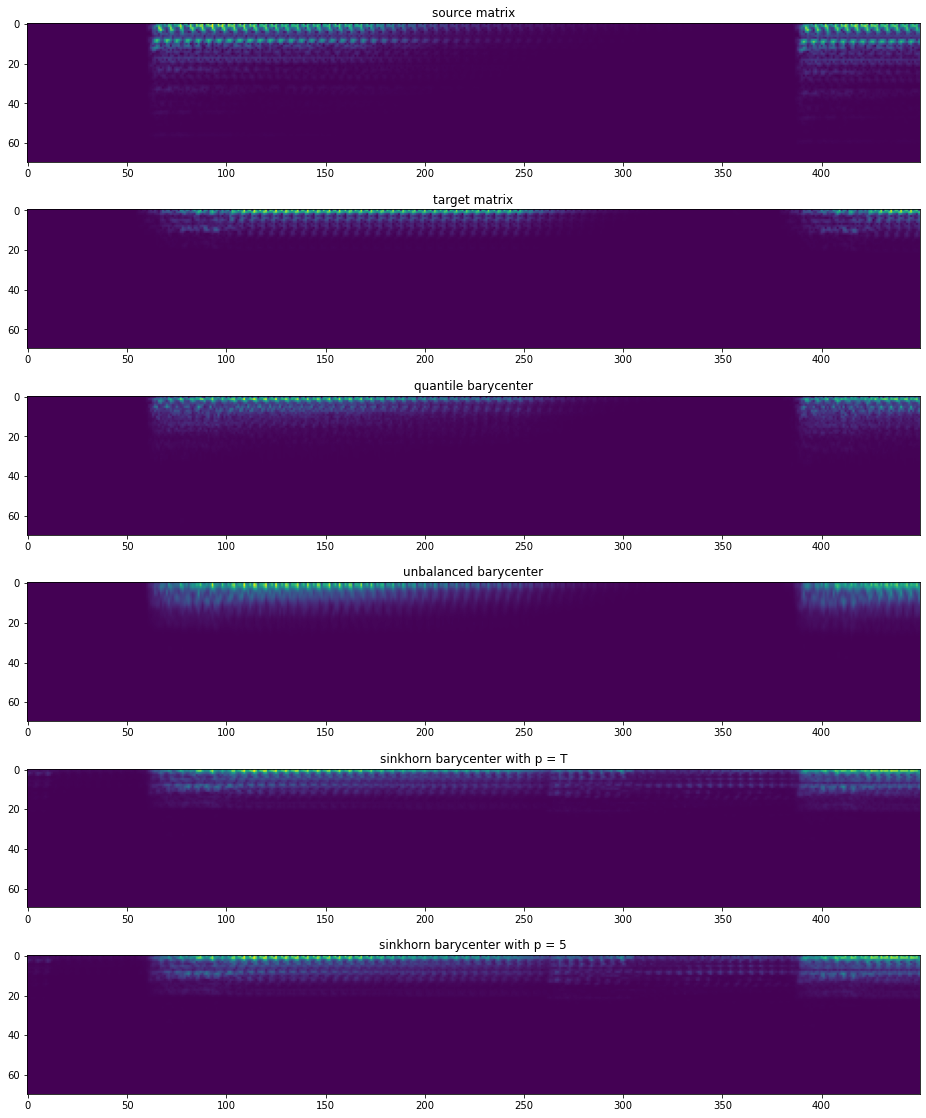

In [141]:
b = 70
t1 = 200
t2 = 650


fig, ax = plt.subplots(6 , 1, figsize=(16,20))
ax[0].imshow(M1[:b,t1:t2])
ax[0].set_title('source matrix')
ax[1].imshow(M2[:b,t1:t2])
ax[1].set_title('target matrix')
ax[2].imshow(M3_quantile[:b,t1:t2])
ax[2].set_title('quantile barycenter')
ax[3].imshow(M3_unbalanced[:b,t1:t2])
ax[3].set_title('unbalanced barycenter')
ax[4].imshow(M3_sinkhorn[:b,t1:t2])
ax[4].set_title('sinkhorn barycenter with p = T')
ax[5].imshow(M3_sinkhorn_2[:b,t1:t2])
ax[5].set_title('sinkhorn barycenter with p = 5')
plt.show()

Comments :
    Results are preety good because
- the quantile barycenter give a good result and sparse
- the unbalanced barycenter give also a good result but it's regularize.
- the sinkhorn barycenter give the expected result and very similar result for $p=T$ and for $p=5$. But we see that mass is displace from a note to an other, so it introduce noise between notes.